## Wealth dynamics


The model of wealth dynamics is:
$$
w_{t+1} = (1 + r_{t+1}) s(w_t) + y_{t+1} 
$$

where

- $ w_t $ is wealth at time $ t $ for a given household,  
- $ r_t $ is the rate of return of financial assets (which are from two types of financial assets explained below),
- $ y_t $ is current non-financial (e.g., labor) income and determined by lognormal
- $ s(w_t) $ is current wealth net of consumption
- $s$ is constant but household who has debt cannot save money

Here, there are two types of financial assets: risk- free assets $a$ and risky assets $s$.
The return of risk-free asset is constant $r_{a}$, while the return of risky assets will be determined by

$$
r_{s,t} =  \exp(\mu(r_{s}) + \sigma_s\epsilon_{s,t})
$$ with $ \epsilon_{s} = N(0,1)$

Household will choose the fraction $\pi$ of $s(w_t)$ which he/she will invest to risky assets $s$.
Assume risk aversion $\rho_{t}$ will be determined by $\rho = \frac{1}{w_{0}}$.

Then household problem will become as follows:
$$
\max_{0<\pi<1} (1-\pi)r_{a} + \pi\mu(r_{s}) - \frac{\rho(w_{0})}{2} \pi^2\sigma_s^2
$$

Solving the first order condition, 

$$
-r_{a} + \mu(r_{s}) - \rho(w_{0})\pi\sigma_s^2 
$$

$$
\rightarrow \pi = \frac{\mu(r_{s}) - r_{a}}{\rho(w_{0})\sigma_s^2}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from numba import float64
from numba.experimental import jitclass

In [3]:
wealth_dynamics_data = [
    ('s', float64),    
    ('μ_y', float64),    
    ('σ_y', float64),    
    ('r_a', float64),    
    ('μ_s', float64),     
    ('σ_s', float64),    
]

In [4]:
@jitclass(wealth_dynamics_data)
class WealthDynamics:

    def __init__(self,
                 s = 0.3,
                 r_a=0.05,
                 μ_s=0.2,
                 σ_s=0.05,):
        self.s, self.r_a, self.μ_s, self.σ_s = s, r_a, μ_s, σ_s

    def states_update(self):
        
        # Update risky assets
        r_s = np.exp(self.μ_s + self.σ_s * np.random.randn())

        # Update income
        y = np.exp(np.random.randn())
        

        return r_s, y

In [5]:
def wealth_update(wdy, time):
    
    
    w_0 = np.exp(np.random.randn()) #initial wealth
    ρ = 1/w_0                                          #risk aversion
    π = (wdy.μ_s - wdy.r_a)/ρ*wdy.σ_s**2 #fraction of saving to invest risky assets
    
    w_t = np.zeros(time)
    w_t[0] = w_0

    for t in range(time-1):
        
        if w_t[t]<0: 
            s = 0 #debt wealth cannot choose to save
        else: 
            s = wdy.s
                
        r_s, y = wdy.states_update()
            
        w_t[t+1] = (1+wdy.r_a)*(1-π)*s*w_t[t] +(1+ r_s)*π*s*w_t[t] + y
        
    return w_t

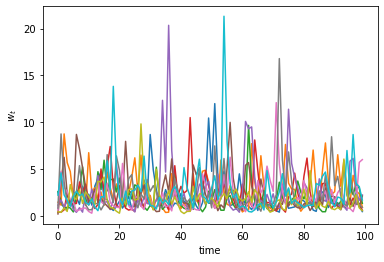

In [6]:
wdy = WealthDynamics()
n =10
time = 100

fig, ax = plt.subplots()

for i in range(n):
    ax.plot(wealth_update(wdy, time))

ax.set(xlabel='time', ylabel='$w_t$')
plt.show()